# Preprocessing

## Part 1  

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
root = Path('Data/Atrium/Task02_Heart/imagesTr/')
label = Path('Data/Atrium/Task02_Heart/labelsTr/')

In [3]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = 'labelsTr'
    return Path(*parts)

In [4]:
sample_path = list(root.glob('la*'))[0]
sample_path_label = change_img_to_label_path(sample_path)

In [5]:
sample_path, sample_path_label

(WindowsPath('Data/Atrium/Task02_Heart/imagesTr/la_003.nii.gz'),
 WindowsPath('Data/Atrium/Task02_Heart/labelsTr/la_003.nii.gz'))

In [7]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [8]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [9]:
from celluloid import Camera
from IPython.display import HTML

<IPython.core.display.Javascript object>


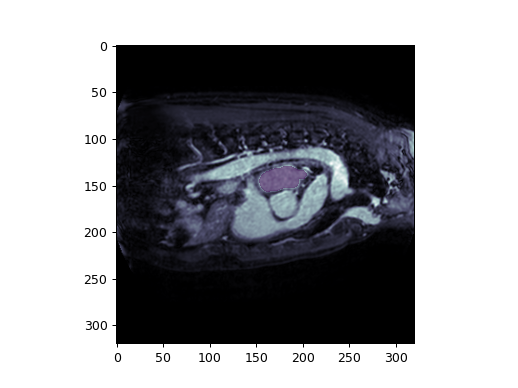

In [10]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap='bone')
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5)
    camera.snap()
    
animation = camera.animate()

In [16]:
HTML(animation.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

## Part 2 

In [18]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [19]:
all_files = list(root.glob('la*'))
len(all_files)

20

In [20]:
save_root = Path('Data/Atrium/Task02_Heart/Preprocessed/')

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ('R', 'A', 'S')
    
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    if counter < 17:
        current_path = save_root / 'train' / str(counter)
    else:
        current_path = save_root / 'val' / str(counter)
    
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:, :, i]
        mask = label_data[:, :, i]
        
        slice_path = current_path / 'data'
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path = current_path / 'masks'
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path / str(i), slice)
        np.save(mask_path / str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
path = Path('Data/Atrium/Task02_Heart/Preprocessed/train/0')

In [22]:
file = '50.npy'
slice = np.load(path / 'data' / file)
mask = np.load(path / 'masks' / file)

<IPython.core.display.Javascript object>


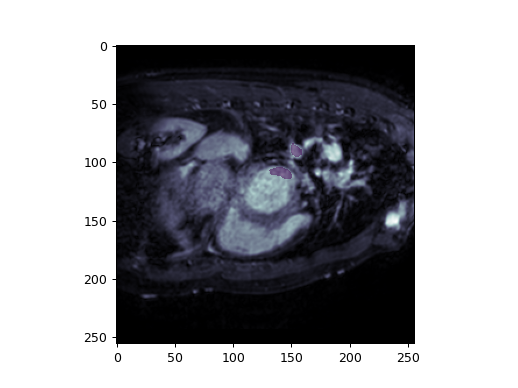

In [24]:
plt.figure()
plt.imshow(slice, cmap='bone')

mask_ = np.ma.masked_where(mask == 0, mask)

plt.imshow(mask_, alpha=0.5);